## Урок 6

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import roc_auc_score
import catboost as ctb
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
import lightgbm as lgb

In [2]:
train = pd.read_csv(r"./train_hw6.csv")
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15 / D15_MEAN_BY_CARD5,D15 / D15_STD_BY_CARD6,D15 / D15_MEAN_BY_CARD6,D15 / D15_STD_BY_ADDR1,D15 / D15_MEAN_BY_ADDR1,D15 / D15_STD_BY_ADDR2,D15 / D15_MEAN_BY_ADDR2,TransactionAmt_int,TransactionAmt_float,TransactionAmt_log
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,0.5,4.226834
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,0.0,3.367296


### Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели

In [3]:
def get_train_and_split(train):
    cat_cols = train.select_dtypes(include=['category', 'object']).columns.tolist()
    
    # Преобразуем сначала object в category, потому что LGBM работает с категорями
    for feature in cat_cols:
        train[feature] = pd.Series(train[feature], dtype="category")
    
    X = train.drop(['isFraud'], axis=1)
    y = train['isFraud']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=99)
    
    return X_train, X_valid, y_train, y_valid, cat_cols

In [4]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "n_estimators": 5,
    "n_jobs": 6,
    "seed": 99
}

In [5]:
X_train, X_valid, y_train, y_valid, cat_cols = get_train_and_split(train)

In [6]:
model_lgbm0 = LGBMClassifier(**params)
model_lgbm0.fit(
    categorical_feature=cat_cols,
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.914372	valid_1's auc: 0.879144


LGBMClassifier(metric='auc', n_estimators=5, n_jobs=6, objective='binary',
               seed=99)

###  Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Text(0.5, 1.0, 'What are the top important features to start with?')

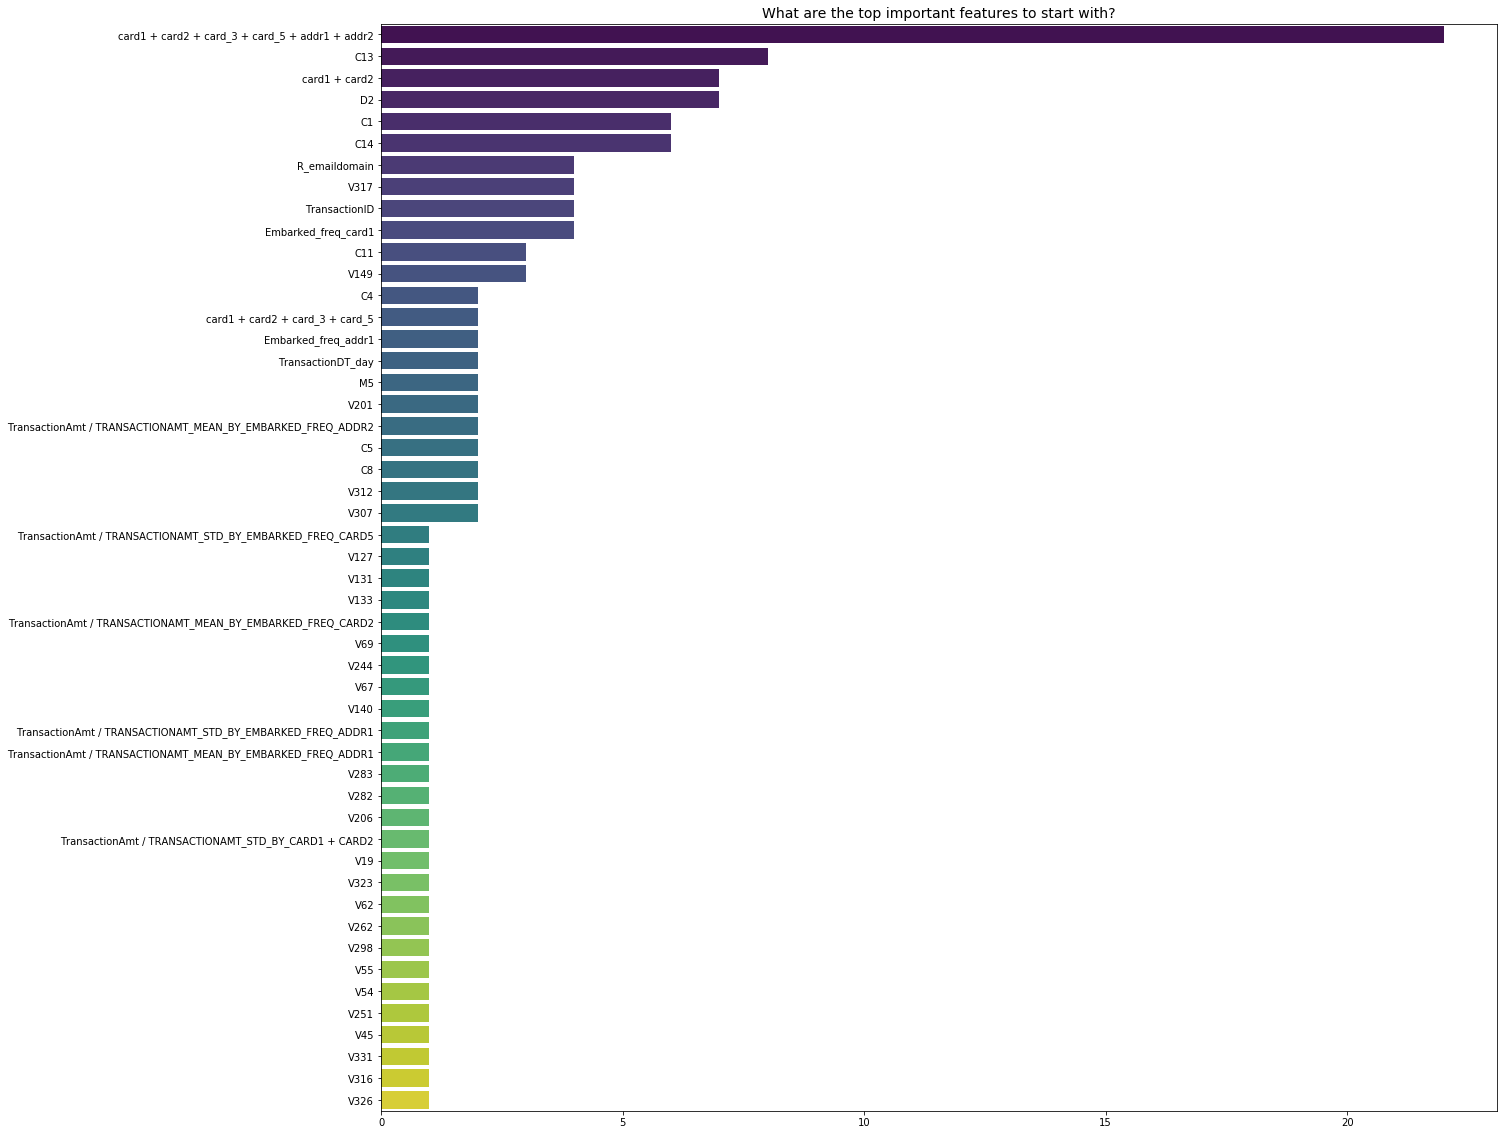

In [7]:
n_top = 50
importances = model_lgbm0.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop('isFraud', axis=1).columns

plt.figure(figsize=(20, 20))
sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis", orient='h')
plt.title("What are the top important features to start with?", size=14)

###  Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [8]:
train2 = train.copy()

In [9]:
droplist = []
for num, feature_profit in enumerate(importances):
    if feature_profit < 3:
        droplist.append(num)
name_list = []        
for name in droplist:
    name_list.append(train2[feature_names[name]].name)
train2 = train2.drop(name_list, axis=1)
train2

,TransactionID,isFraud,R_emaildomain,C1,C11,C13,C14,D2,V149,V317,card1 + card2,card1 + card2 + card_3 + card_5 + addr1 + addr2,Embarked_freq_card1
0,2987000,0,NaN,1.0,2.0,1.0,1.0,NaN,NaN,117.0,13926 | nan,13926 | nan | 150.0 | 142.0 | 315.0 | 87.0,0.000061
1,2987001,0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,0.0,2755 | 404.0,2755 | 404.0 | 150.0 | 102.0 | 325.0 | 87.0,0.001244
2,2987002,0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,0.0,4663 | 490.0,4663 | 490.0 | 150.0 | 166.0 | 330.0 | 87.0,0.001428
3,2987003,0,NaN,2.0,1.0,25.0,1.0,112.0,NaN,1404.0,18132 | 567.0,18132 | 567.0 | 150.0 | 117.0 | 476.0 | 87.0,0.006600
4,2987004,0,NaN,1.0,1.0,1.0,1.0,NaN,0.0,0.0,4497 | 514.0,4497 | 514.0 | 150.0 | 102.0 | 420.0 | 87.0,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,NaN,2.0,2.0,5.0,2.0,20.0,NaN,474.5,1877 | 310.0,1877 | 310.0 | 150.0 | 224.0 | 272.0 | 87.0,0.000139
179996,3166996,0,NaN,4.0,2.0,16.0,4.0,239.0,NaN,0.0,10075 | 514.0,10075 | 514.0 | 150.0 | 224.0 | 315.0 | 87.0,0.000483
179997,3166997,0,NaN,2.0,1.0,1.0,1.0,NaN,NaN,0.0,6053 | 122.0,6053 | 122.0 | 150.0 | 195.0 | 330.0 | 87.0,0.001067
179998,3166998,0,NaN,1.0,1.0,24.0,1.0,361.0,NaN,0.0,7726 | 555.0,7726 | 555.0 | 150.0 | 226.0 | 272.0 | 87.0,0.000028


In [10]:
X_train2, X_valid2, y_train2, y_valid2, cat_cols2 = get_train_and_split(train2)

In [11]:
model_lgbm2 = LGBMClassifier(**params)
model_lgbm2.fit(
    categorical_feature=cat_cols2,
    X=X_train2,
    y=y_train2,
    eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=100
)

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.904012	valid_1's auc: 0.864495


LGBMClassifier(metric='auc', n_estimators=5, n_jobs=6, objective='binary',
               seed=99)

Text(0.5, 1.0, 'What are the top important features to start with?')

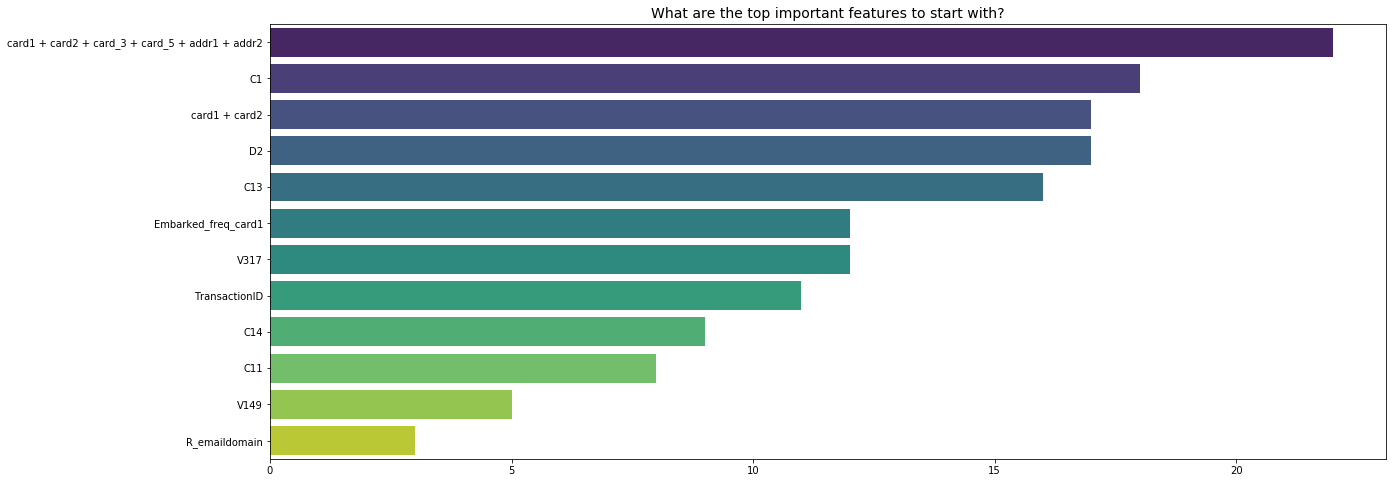

In [12]:
n_top = 50
importances = model_lgbm2.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train2.drop('isFraud', axis=1).columns

plt.figure(figsize=(20, 8))
sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis", orient='h')
plt.title("What are the top important features to start with?", size=14)

Качество на валидации снизилось на менее, чем на 2%, что говорит о том, что удаленные признаки не вносили существенного вклада и качество осталось почти что таким же.

### Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [13]:
# Возьмем только часть признаков(все оставшиеся признаки после удаления из задания 2), 
# поскольку все 488 признаков из задания1 permutation importance перебирает очень долго!

In [14]:
from sklearn.inspection import permutation_importance

#из задания 1
importance = permutation_importance(
    model_lgbm2, X_valid2, y_valid2, scoring="roc_auc", n_jobs=6, random_state=99
)

importance_scores = pd.DataFrame({
    "features": X_valid2.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=100]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores

,features,importance-mean,importance-std
0,card1 + card2 + card_3 + card_5 + addr1 + addr2,0.046532,0.002575
1,C1,0.035025,0.001766
2,card1 + card2,0.028191,0.001679
3,C14,0.024251,0.001747
4,R_emaildomain,0.023102,0.001546
5,V317,0.017999,0.001078
6,C13,0.007182,0.000420
7,Embarked_freq_card1,0.005570,0.000316
8,V149,0.004488,0.000250
9,D2,0.004427,0.000363


In [15]:
# from eli5.sklearn import PermutationImportance
# from eli5 import show_weights

# estimator = PermutationImportance(
#     model_lgbm2, scoring="roc_auc", random_state=99
# )
# importance = estimator.fit(X_valid2.fillna(-9999), y_valid2)

# show_weights(importance, feature_names=X_valid2.columns.tolist(), top=X_valid2.shape[1])
# scores, importance = calculate_permutation_importance(
#     model_lgbm2, roc_auc_score, X_valid2, y_valid2
# )

permutation_importance значительно изменило рейтинг признаков, например, R_emaildomain стал иметь большее значение!

### Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [16]:
# !pip install boostaroota
from boostaroota import BoostARoota
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:

    for ii in X.select_dtypes(include=['object', 'category']).columns.tolist():
        X[ii] = X[ii].astype(str)

    for ii in X.select_dtypes(exclude=['object', 'category']).columns.tolist():
        X[ii] = X[ii].fillna(0)
    X = X.replace([-np.inf, np.inf], [0, 0])

    hash_space = 0.1
    for item_column in tqdm(X.select_dtypes(include=['object', 'category']).columns.tolist()):
        for itm in X[item_column].value_counts().index.tolist():
            X.loc[X[item_column] == itm, item_column] = (hash(itm) % hash_space)

        X[item_column] = X[item_column].astype('float')

    return X

In [17]:
data_ = prepare_data(train2.copy())

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [11:39<00:00, 233.32s/it]


In [18]:
data_.head(3)

,TransactionID,isFraud,R_emaildomain,C1,C11,C13,C14,D2,V149,V317,card1 + card2,card1 + card2 + card_3 + card_5 + addr1 + addr2,Embarked_freq_card1
0,2987000,0,0.022064,1.0,2.0,1.0,1.0,0.0,0.0,117.0,0.080699,0.026280,0.000061
1,2987001,0,0.022064,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.004800,0.099920,0.001244
2,2987002,0,0.022064,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.065875,0.038374,0.001428


In [19]:
# С такими признаками затруднительно сделать OneHotEncoding, признаков получится крайне много! 
data_['card1 + card2 + card_3 + card_5 + addr1 + addr2'].nunique()

25887

In [20]:
data_['card1 + card2'].nunique()

9636

In [ ]:
# Можно разве что этот призкак перевести в дамми
# data_['R_emaildomain']

In [21]:
data_ = pd.get_dummies(data_, columns=['R_emaildomain'])

In [22]:
data_.head(3)

,TransactionID,isFraud,C1,C11,C13,C14,D2,V149,V317,card1 + card2,...,R_emaildomain_0.076393215064129,R_emaildomain_0.0775839703836709,R_emaildomain_0.07987833181723603,R_emaildomain_0.08128781873957511,R_emaildomain_0.08403123941616869,R_emaildomain_0.08423617339746695,R_emaildomain_0.09261481709705346,R_emaildomain_0.09468879371469863,R_emaildomain_0.09567314174401237,R_emaildomain_0.09633632556092567
0,2987000,0,1.0,2.0,1.0,1.0,0.0,0.0,117.0,0.080699,...,0,0,0,0,0,0,0,0,0,0
1,2987001,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.004800,...,0,0,0,0,0,0,0,0,0,0
2,2987002,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.065875,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train3, X_valid3, y_train3, y_valid3, cat_cols3 = get_train_and_split(data_)

In [24]:
model_lgbm_old = LGBMClassifier(**params)
model_lgbm_old.fit(
    categorical_feature=cat_cols3,
    X=X_train3,
    y=y_train3,
    eval_set=[(X_train3, y_train3), (X_valid3, y_valid3)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=100
)

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.832598	valid_1's auc: 0.827414


LGBMClassifier(metric='auc', n_estimators=5, n_jobs=6, objective='binary',
               seed=99)

In [25]:
br = BoostARoota(metric='auc', iters=20, max_rounds=3)
br.fit(X_train3, y_train3)

[03:16:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[03:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[03:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

Round:  2  iteration:  1
[03:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  2  iteration:  2
[03:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  2  iteration:  3
[03:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may n

In [26]:
br.keep_vars_

0                                       TransactionID
1                                                  C1
2                                                 C11
3                                                 C13
4                                                 C14
5                                                  D2
6                                                V149
7                                                V317
8                                       card1 + card2
9     card1 + card2 + card_3 + card_5 + addr1 + addr2
10                                Embarked_freq_card1
11                 R_emaildomain_0.005171003202313618
12                 R_emaildomain_0.009647151190899206
13                 R_emaildomain_0.014819608756472563
14                 R_emaildomain_0.018165658474455337
15                 R_emaildomain_0.022063666775625795
16                  R_emaildomain_0.03450726466764267
17                 R_emaildomain_0.040017592788980594
18                  R_emaild

In [27]:
x_train_br = br.transform(X_train3)
x_valid_br = br.transform(X_valid3)


In [28]:
model_lgbm_new = LGBMClassifier(**params)
model_lgbm_new.fit(
    categorical_feature=cat_cols3,
    X=x_train_br,
    y=y_train3,
    eval_set=[(x_train_br, y_train3), (x_valid_br, y_valid3)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=100
)


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.832598	valid_1's auc: 0.827414


LGBMClassifier(metric='auc', n_estimators=5, n_jobs=6, objective='binary',
               seed=99)

Разницы в качестве на тестовой и на валидационной выборках не наблюдается, однако сократилось пространство признаков.

### Задание 5: использовать shap, выполнить задание 1 и 2.

In [29]:
# !pip install shap
import shap
explainer = shap.TreeExplainer(model_lgbm0)
shap_values = explainer.shap_values(X_valid, y_valid)

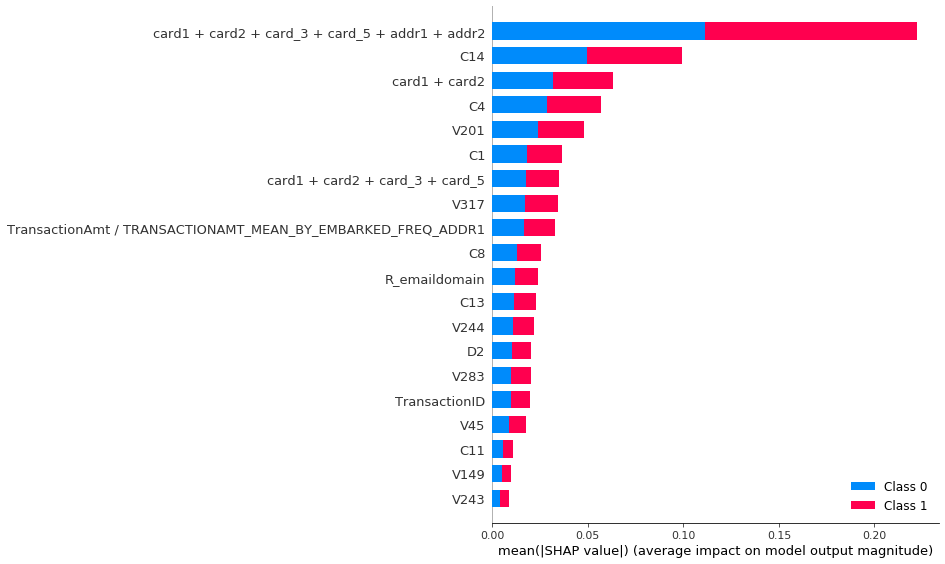

In [30]:
shap.summary_plot(shap_values, X_valid, plot_type="bar", max_display=20)

In [31]:
shap_feature_importance = pd.DataFrame(list( zip(X_valid.columns, np.abs(shap_values).mean(0)) ),columns=['feature','shap_values'])
shap_feature_importance['shap_values'] = shap_feature_importance['shap_values'].mean()
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)
shap_feature_importance.head(10)

,feature,shap_values
400,card1 + card2 + card_3 + card_5 + addr1 + addr2,0.110960
29,C14,0.048248
398,card1 + card2,0.031962
19,C4,0.028302
254,V201,0.023342
16,C1,0.020445
370,V317,0.017919
399,card1 + card2 + card_3 + card_5,0.017754
428,TransactionAmt / TRANSACTIONAMT_MEAN_BY_EMBARK...,0.017471
297,V244,0.014640


In [32]:
X_train5, X_valid5, y_train5, y_valid5, cat_cols5 = get_train_and_split(data_)

In [33]:
list_to_drop = shap_feature_importance[100:]['feature'].tolist()
model_lgbm5 = LGBMClassifier(**params)
model_lgbm5.fit(
#     categorical_feature=cat_cols,
    X=X_train.drop(list_to_drop, axis=1),
    y=y_train,
    eval_set=[(X_train.drop(list_to_drop, axis=1), y_train), (X_valid.drop(list_to_drop, axis=1), y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=100
)


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.914372	valid_1's auc: 0.879144


LGBMClassifier(metric='auc', n_estimators=5, n_jobs=6, objective='binary',
               seed=99)

Результат на валидации по сравнению с первой моделью в первом задании не изменился.

### Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [34]:
# Обучим другую модель XGBoost и построим shap

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(data_.drop(columns='isFraud'),
                                                      data_['isFraud'],shuffle=False,
                                                      train_size=0.8)

In [36]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 5,
    "gamma": 10,
    "nthread": -1,
    "seed": 99
}

In [37]:
train_xgb = xgb.DMatrix(data=X_train,
                            label=y_train
                            )

valid_xgb = xgb.DMatrix(data=X_valid,
                            label=y_valid,
                            )

In [38]:
model = xgb.train(
    params=params,
    dtrain=train_xgb,
    num_boost_round=300,
    early_stopping_rounds=50,
    evals=[(train_xgb, "train"), (valid_xgb, "valid")],
    verbose_eval=100,
    maximize=True,
)

[0]	train-auc:0.76920	valid-auc:0.75639
[97]	train-auc:0.91563	valid-auc:0.89159


In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid, y_valid)

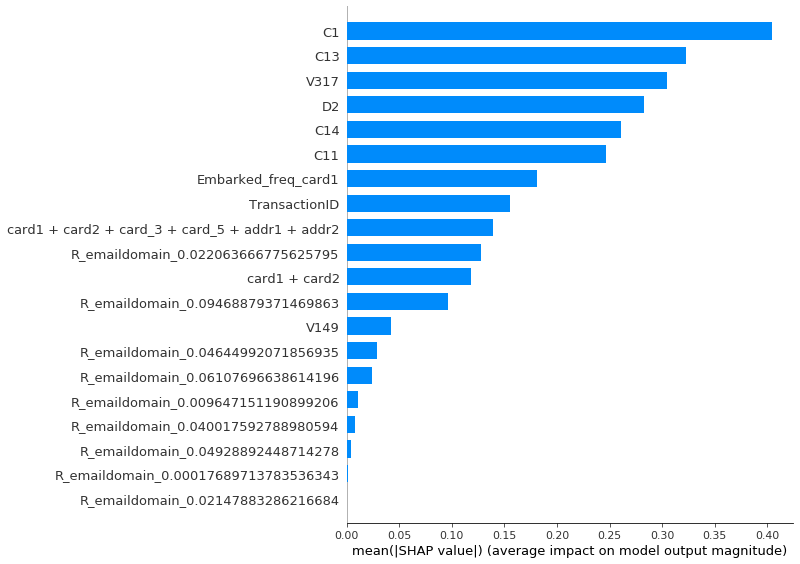

In [40]:
shap.summary_plot(shap_values, X_valid, plot_type="bar", max_display=20)

In [42]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:], link="logit"
)

In [43]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-3.97159054]


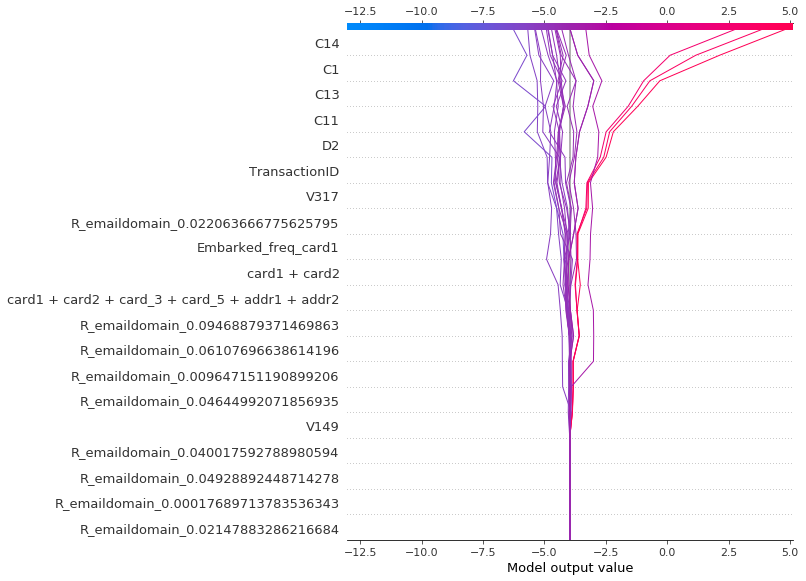

In [44]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20])

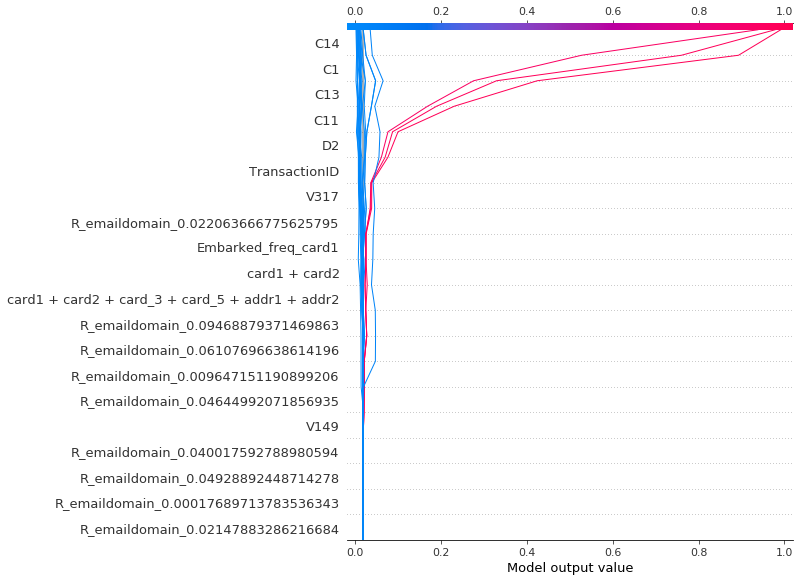

In [45]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

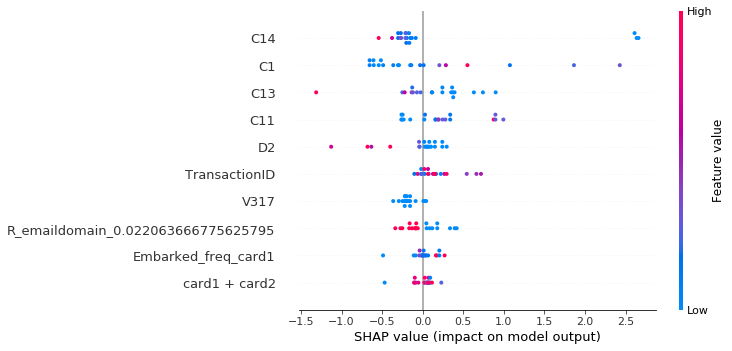

In [48]:
shap.summary_plot(shap_values, X_valid[:20], max_display=10)

Выводы: После прохождения признаков С14, С1, С13, С11 вероятность дефолта значительно возрастает. Однако 6 задание было выполнено с использованием XGBoost, а 5 задание с использованием lgbm. Видно, что shap и XGBoost кардинально по-другому оценили вклад признаков при том, что lgbm обучался на 488 признаках, а XGBoost на 12 лучших отобранных. Например, XGBoost понизил значение признака "card1+card2+card_3+card_5+addr1+addr2", а для lgbm это был важнейший признак.